> In this paper, we propose a novel weight normalization technique called spectral normalization to stabilize the training of the discriminator.
Our new normalization technique is computationally light and easy to incorporate
into existing implementations. We tested the efficacy of spectral normalization on
CIFAR10, STL-10, and ILSVRC2012 dataset, and we experimentally confirmed
that spectrally normalized GANs (SN-GANs) is capable of generating images of
better or equal quality relative to the previous training stabilization techniques.
The code with Chainer (Tokui et al., 2015), generated images and pretrained models are available at https://github.com/pfnet-research/sngan_
projection. 

> [Source](https://openreview.net/pdf?id=B1QRgziT-)

In [68]:
# import All prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ROOT = "/content/drive/My Drive/Colab Notebooks/DSC_UI_GAN/Batch1/W2/WGAN-SN"
sample_dir = os.path.join(ROOT, 'sample')
# Make dir if no exist
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [69]:
batch_size = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



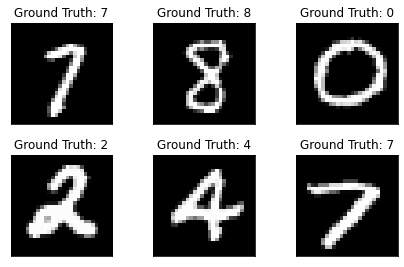

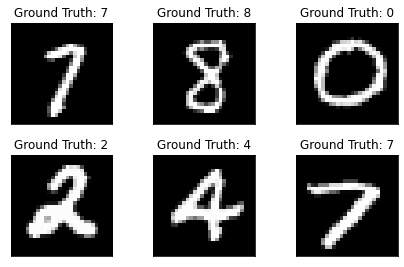

In [70]:
## Print example
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

##Make Spectral Normalization

In [71]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

##Build Models
###Generator Model

In [72]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(g_input_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, g_output_dim), 
            nn.Tanh())

    def forward(self, z):
        image = self.model(z)
        image = image.view(image.size(0), -1)
        return image

##Discriminator Model

In [73]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            SpectralNorm(nn.Linear(d_input_dim, 512)),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Linear(256, 1)),
            nn.Sigmoid(),
        )

    def forward(self, image):
        img_flat = image.view(image.size(0), -1)
        validity = self.model(img_flat)
        return validity

##Builda Network

In [74]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)
print(G, D)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
) Discriminator(
  (model): Sequential(
    (0): SpectralNorm(
      (module): Linear(in_features=784, out_features=512, bias=True)
    )
    (1): LeakyRe

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


##Train Process

In [75]:
# optimizer
lr = 0.0002
n_critic =  5
b1 = 0.5
b2 = 0.999

G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(b1, b2))
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(b1, b2))
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
epochs = 200
batches_done = 0
list_loss_D = []
list_loss_G = []
for epoch in range(epochs):

    for i, (imgs, _) in enumerate(train_loader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        D_optimizer.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], z_dim))))

        # Generate a batch of images
        fake_imgs = G(z).detach()
        # Adversarial loss
        d_loss = -torch.mean(D(real_imgs)) + torch.mean(D(fake_imgs))

        d_loss.backward()
        D_optimizer.step()

        # Train the generator every n_critic iterations
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            G_optimizer.zero_grad()

            # Generate a batch of images
            gen_imgs = G(z)
            # Adversarial loss
            g_loss = -torch.mean(D(gen_imgs))

            g_loss.backward()
            G_optimizer.step()

            # add loss to list
            list_loss_D.append(d_loss.item())
            list_loss_G.append(g_loss.item())
        
        if i % 300 == 0:
            print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, epochs, i, len(train_loader), d_loss.item(), g_loss.item()))

    if epoch % 5 == 0:
        save_image(gen_imgs.view(gen_imgs.size(0), 1, 28, 28), os.path.join(sample_dir, "%d.png" % epoch), nrow=5, normalize=True)

torch.save(G, os.path.join(ROOT, 'G.pt'))
torch.save(D, os.path.join(ROOT, 'D.pt'))

[Epoch 0/200] [Batch 0/600] [D loss: 0.071756] [G loss: -0.501077]
[Epoch 0/200] [Batch 300/600] [D loss: -0.646319] [G loss: -0.333079]
[Epoch 1/200] [Batch 0/600] [D loss: -0.567875] [G loss: -0.171440]
[Epoch 1/200] [Batch 300/600] [D loss: -0.606923] [G loss: -0.191885]
[Epoch 2/200] [Batch 0/600] [D loss: -0.671416] [G loss: -0.135475]
[Epoch 2/200] [Batch 300/600] [D loss: -0.710118] [G loss: -0.131132]
[Epoch 3/200] [Batch 0/600] [D loss: -0.621722] [G loss: -0.168165]
[Epoch 3/200] [Batch 300/600] [D loss: -0.649618] [G loss: -0.169899]
[Epoch 4/200] [Batch 0/600] [D loss: -0.622129] [G loss: -0.210062]
[Epoch 4/200] [Batch 300/600] [D loss: -0.655196] [G loss: -0.197507]
[Epoch 5/200] [Batch 0/600] [D loss: -0.627409] [G loss: -0.161746]
[Epoch 5/200] [Batch 300/600] [D loss: -0.622146] [G loss: -0.222963]
[Epoch 6/200] [Batch 0/600] [D loss: -0.598501] [G loss: -0.190483]
[Epoch 6/200] [Batch 300/600] [D loss: -0.588758] [G loss: -0.168030]
[Epoch 7/200] [Batch 0/600] [D loss